In [1]:
# from google.colab import drive # Il faut pouvoir lire les fichiers CSV du Drive
# drive.mount('/content/drive')

In [1]:
# pip install tensorflow_datasets

In [1]:
%matplotlib inline
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import shutil
import os
import csv
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB7, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [2]:
tf.config.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:

# with open("/content/drive/MyDrive/Hackathon IA/Bike helmet detection/labels_faces.csv" , "r") as file:
#     spamwriter = csv.read(file)
#     for row in spamreader:
#       Y.append(row[1])

In [4]:
folder = "Faces/train"
print(len(os.listdir("Faces/train/sans_casque")))

6240


In [3]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
CLASSES = 2
INNER_NODES = 10

In [4]:
class DataCreator:
    def train_generators(self, validation_split = 0.1, batch_size = 4):
        train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                           horizontal_flip=True,
                                           dtype='float16')
        
        # Constant seed is required to avoir mixing train and dev data 
        # while keeping the same model when excecuting the program multiple times
        
        train_generator = train_datagen.flow_from_directory(
            'Faces/train/',
            target_size=(IMG_SIZE,IMG_SIZE),
            color_mode='rgb',
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True,
            seed = 1)
        
        val_generator = train_datagen.flow_from_directory(
            'Faces/val/',
            target_size=(IMG_SIZE,IMG_SIZE),
            color_mode='rgb',
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True,
            seed = 1)    
        
        return train_generator,val_generator 
    
    def predict_generator(self):
        pred_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, dtype='float16')    
        test_generator = pred_datagen.flow_from_directory(
            directory= 'Faces/test/',
            target_size=(IMG_SIZE, IMG_SIZE),
            color_mode="rgb",
            shuffle = False,
            class_mode='categorical',
            batch_size=1,
            seed = 1)
        return test_generator

In [7]:
class Network:
    
    def __init__(self,classes=2,inner_nodes=64,name = 'nn1',learning_rate = 0.0001, regularization = 0.001):#,train_batches,validation_batches,test_batches):
        self.name = name
        
        # Create the base model from the pre-trained model MobileNet V2
        base_model = EfficientNetB7(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
        
        X=base_model.output
        X=GlobalAveragePooling2D()(X)
        X = Dropout(0.2)(X)
        X=Dense(inner_nodes,activation='relu')(X) #, kernel_regularizer=regularizers.l2(regularization)
        X = Dropout(0.2)(X)
        preds=Dense(classes,activation='softmax')(X)
        
        self.model=Model(inputs=base_model.input,outputs=preds)
        
        self.model.compile(optimizer=Adam(lr=learning_rate),
                           loss=CategoricalCrossentropy(from_logits=True),
                           metrics=['accuracy'])
        
        
    
    def train(self,train_generator,validation_generator,epochs,verbose = 1):
        step_size_train=train_generator.n//train_generator.batch_size
        step_size_val=validation_generator.n//validation_generator.batch_size
        
        history = self.model.fit(train_generator,
                                 steps_per_epoch = step_size_train,
                                 validation_data = validation_generator, 
                                 validation_steps = step_size_val,
                                 epochs=epochs, verbose=verbose)   
        return history     
    
    def predict(self,pred_generator,labels,verbose = 1):
        step_size_pred=pred_generator.n//pred_generator.batch_size
        pred_generator.reset()
        pred=self.model.predict(pred_generator,
                                steps=step_size_pred,
                                verbose=verbose)
        
        predicted_class_indices=np.argmax(pred,axis=1)
        labels = dict((v,k) for k,v in (labels).items())
        predictions = [labels[k] for k in predicted_class_indices]
        filenames = pred_generator.filenames
        return [predictions, filenames]
    
    def load(self, name = None):
        if name == None:name = self.name
        self.model.load_weights('models/weights of '+name+'.nn')
    
    def save(self, name = None):
        if name == None:name = self.name
        self.model.save_weights('models/weights of '+name+'.nn')
    
    def plot_learning_curves(self,history):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        
        plt.figure(figsize=(8, 8))
        plt.subplot(2, 1, 1)
        plt.plot(acc, label='Training Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.ylabel('Accuracy')
        plt.ylim([min(plt.ylim()),1])
        plt.title('Training and Validation Accuracy')
        
        plt.subplot(2, 1, 2)
        plt.plot(loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.ylabel('Cross Entropy')
        plt.ylim([0,1.0])
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
        plt.show()  

In [5]:
train_gen,val_gen = DataCreator().train_generators()
pred_gen = DataCreator().predict_generator()

Found 18900 images belonging to 2 classes.
Found 112 images belonging to 2 classes.
Found 42 images belonging to 1 classes.


42/42 [==============================] - 22s 65ms/step
test/face1065_43_True.png belongs to casque
test/face11485_443_True.png belongs to casque
test/face11486_443_True.png belongs to casque
test/face11487_443_True.png belongs to casque
test/face11488_443_True.png belongs to casque
test/face11489_443_True.png belongs to casque
test/face12699_498_True.png belongs to casque
test/face12880_507_False.png belongs to sans_casque
test/face12881_507_True.png belongs to casque
test/face12882_507_False.png belongs to sans_casque
test/face12883_508_True.png belongs to casque
test/face13034_515_True.png belongs to casque
test/face13035_515_True.png belongs to casque
test/face13036_515_True.png belongs to casque
test/face13037_515_True.png belongs to casque
test/face13431_530_True.png belongs to casque
test/face13432_530_True.png belongs to casque
test/face13433_530_True.png belongs to casque
test/face14538_577_False.png belongs to sans_casque
test/face15125_604_False.png belongs to sans_casque
tes

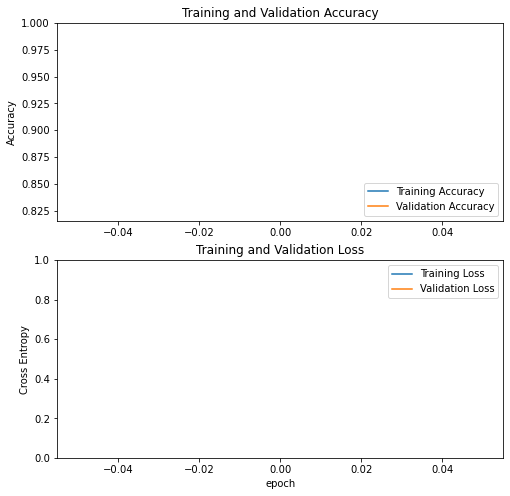

In [8]:
net = Network(classes = CLASSES,inner_nodes = INNER_NODES, name = 'my predictor',learning_rate=0.0003, regularization = 0.2)

#net.load()

hist = net.train(train_gen, val_gen, 1, verbose = 1)

net.save()

pred,filenames = net.predict(pred_gen, train_gen.class_indices,verbose = 1)
for i in range(len(pred)):
    print(filenames[i]+' belongs to '+pred[i])

# Plots loss and accuracy histories on the train and dev set
net.plot_learning_curves(hist)

4725/4725 [==============================] - 2185s 459ms/step - loss: 0.2810 - accuracy: 0.8960 - val_loss: 0.5570 - val_accuracy: 0.8214

# Exemples d'images bien catégorisées

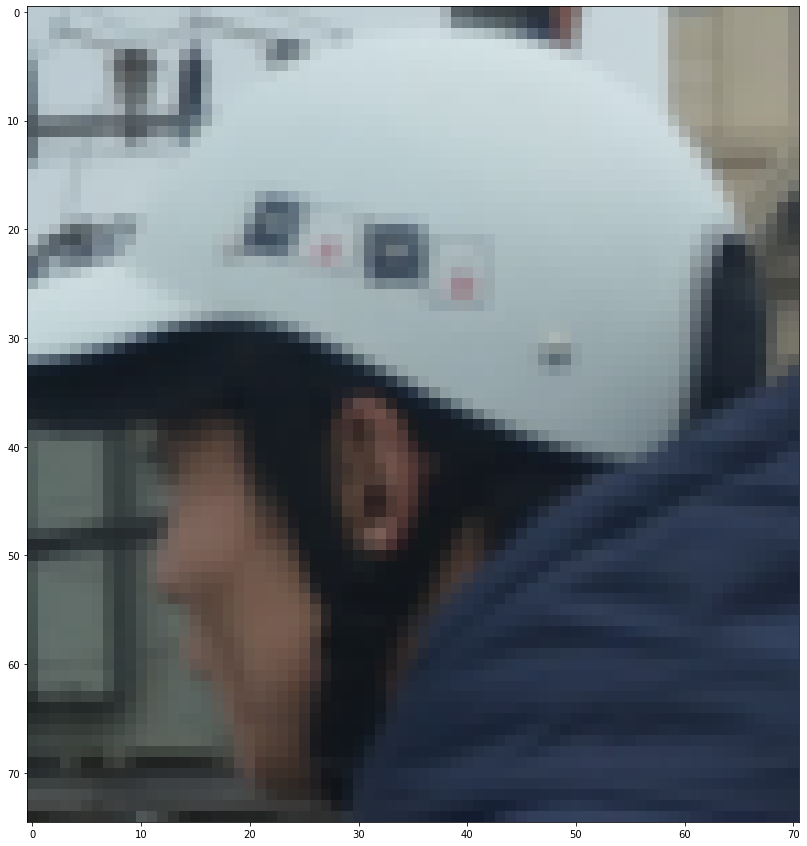

In [10]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(Image.open("Faces/test/test/face866_33_True.png"))

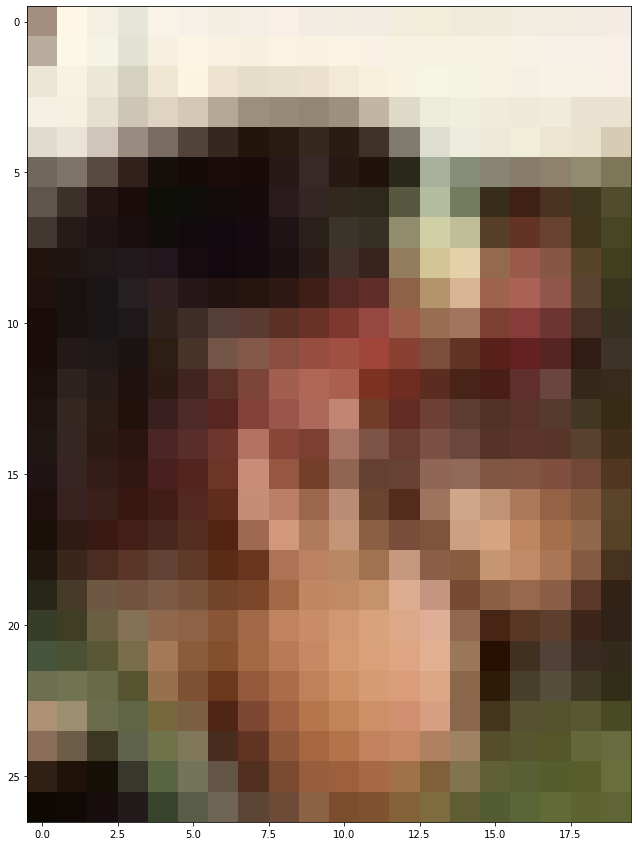

In [13]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(Image.open("Faces/test/test/face15128_604_False.png"))

# Images mal classifiées par ce modèle...

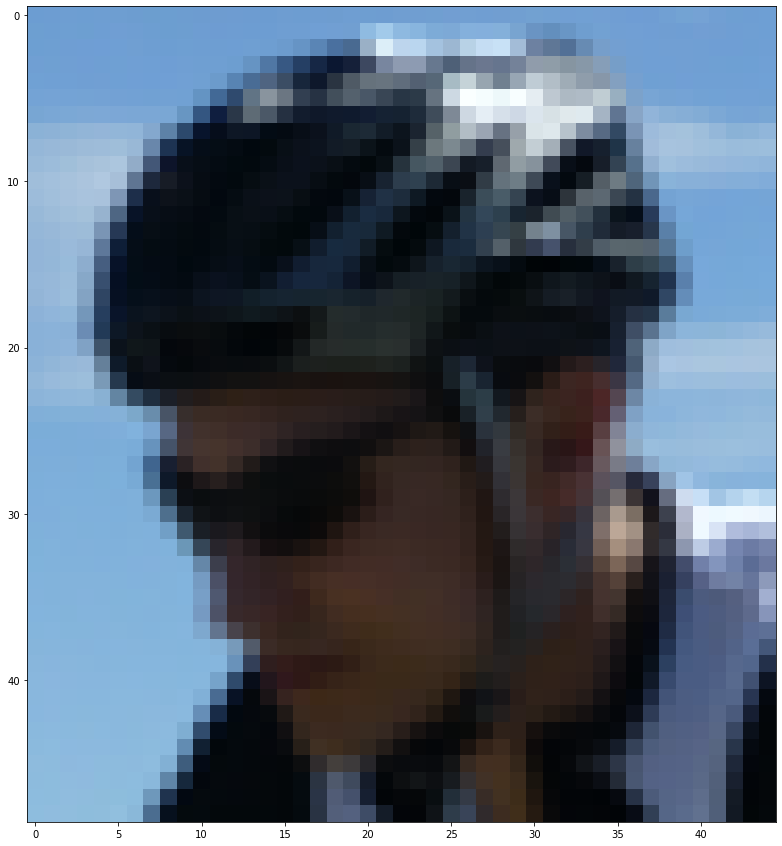

In [14]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(Image.open("Faces/test/test/face18872_758_True.png"))

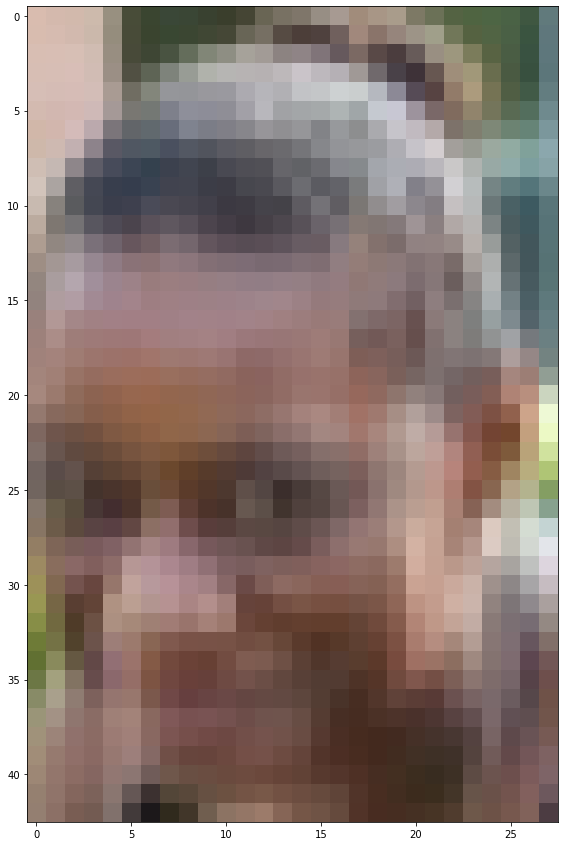

In [15]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(Image.open("Faces/test/test/face12882_507_False.png"))